In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.100)

import numpy as np
import time
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

3198 > 3136 edges
Layer 0: M_0 = |V| = 992 nodes (208 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 496 nodes (86 added),|E| = 1411 edges
Layer 2: M_2 = |V| = 248 nodes (32 added),|E| = 661 edges
Layer 3: M_3 = |V| = 124 nodes (8 added),|E| = 328 edges
Layer 4: M_4 = |V| = 62 nodes (0 added),|E| = 165 edges
Execution time: 0.23s


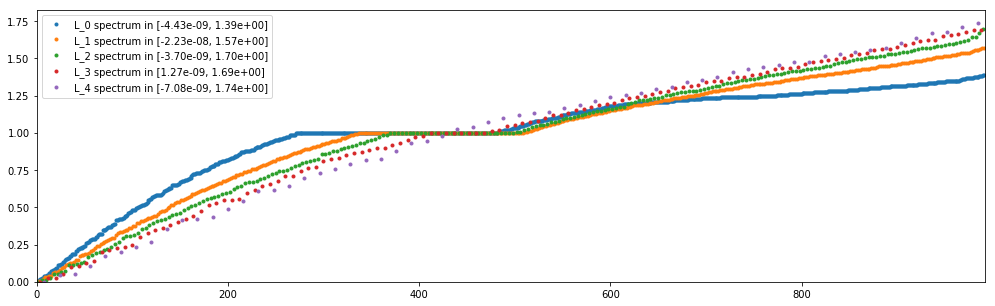

In [3]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = np_utils.to_categorical(mnist.train.labels)
val_labels = np_utils.to_categorical(mnist.validation.labels)
test_labels = np_utils.to_categorical(mnist.test.labels)

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
print(test_data.shape)
del perm

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Execution time: 1.05s


# Neural networks

In [5]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [8]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 2
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(mnist.train.labels) + 1  # number of classes

model_perf = utils.model_perf()

In [9]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['F_0']            = 1
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 992 * 10 = 9920
    biases: M_1 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 6.58e-01
  validation accuracy: 85.26 (4263 / 5000), f1 (weighted): 0.00, loss: 5.73e-01
  time: 1s (wall 1s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 4.95e-01
  validation accuracy: 87.36 (4368 / 5000), f1 (weighted): 0.00, loss: 4.81e-01
  time: 1s (wall 1s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-02, loss_average = 4.76e-01
  validation accuracy: 88.68 (4434 / 5000), f1 (weighted): 0.00, loss: 4.37e-01
  time: 2s (wall 2s)
step 240 / 1100 (epoch 0.44 / 2):
  learning_rate = 2.00e-02, loss_average = 4.20e-01
  validation accuracy: 89.34 (4467 / 5000), f1 (weighted): 0.00, loss: 4.11e-01
  time: 2s (wall 2s)
step 300 / 1100 (epoch 0.55 / 2):
  learning_rate = 2.00e-02, loss_average = 4.37e-01
  validation 

In [22]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['F_0']            = 1
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 10 / 1 = 9920
    weights: F_0 * F_1 * K_1 = 1 * 10 * 992 = 9920
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9920 * 10 = 99200
    biases: M_2 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 2.03e+00
  validation accuracy: 52.78 (2639 / 5000), f1 (weighted): 0.00, loss: 1.90e+00
  time: 2s (wall 3s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 1.06e+00
  validation accuracy: 76.78 (3839 / 5000), f1 (weighted): 0.00, loss: 8.95e-01
  time: 3s (wall 6s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-02, loss_average = 6.18e-01
  validation accuracy: 83.12 (4156 / 5000), f1 (weighted): 0.00, loss: 6.03e-01
  time: 5s (wall 9s)


In [14]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 10 / 1 = 9920
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9920 * 10 = 99200
    biases: M_2 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 1.03e+00
  validation accuracy: 76.98 (3849 / 5000), f1 (weighted): 0.00, loss: 7.42e-01
  time: 2s (wall 3s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 5.00e-01
  validation accuracy: 87.70 (4385 / 5000), f1 (weighted): 0.00, loss: 4.31e-01
  time: 3s (wall 6s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-02, loss_average = 4.42e-01
  validation accuracy: 88.52 (4426 / 5000), f1 (weighted): 0.00, loss: 3.96e-01
  time: 5s (wall 9s)
step 240 / 1100 (epoch 0.44 / 2):
  learning_rate = 2.00e-02, loss_average = 3.82e-01
  validation accuracy: 89.24 (4462 / 5000), f1 (wei

In [15]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 10 / 1 = 9920
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 9920 * 10 = 99200
    biases: M_2 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 4.51e-01
  validation accuracy: 88.46 (4423 / 5000), f1 (weighted): 0.00, loss: 3.89e-01
  time: 3s (wall 6s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 3.38e-01
  validation accuracy: 90.82 (4541 / 5000), f1 (weighted): 0.00, loss: 3.18e-01
  time: 6s (wall 11s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-02, loss_average = 2.94e-01
  validation accuracy: 92.24 (4612 / 5000), f1 (weighted): 0.00, loss: 2.63e-01
  time: 9s (wall 16s)
step 240 / 1100 (epoch 0.44 / 2):
  learning_rate = 2.00e-02, loss_average = 2.29e-01
  validation accuracy: 93.74 (4687 / 5000), f1 (w

In [17]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['F_0']            = 1
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [18]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 32 / 4 = 7936
    weights: F_0 * F_1 * K_1 = 1 * 32 * 992 = 31744
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 248 * 64 / 4 = 3968
    weights: F_1 * F_2 * K_2 = 32 * 64 * 248 = 507904
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3968 * 512 = 2031616
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 6.18e+00
  validation accuracy: 13.48 (674 / 5000), f1 (weighted): 0.00, loss: 6.17e+00
  time: 5s (wall 13s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 6.04e+00
  validation accuracy: 35.38 (1769 / 5000), f1 (weighted): 0.00, loss: 5.98e+00
  time: 10s (wall 24s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00

In [19]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 32 / 4 = 7936
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 248 * 64 / 4 = 3968
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3968 * 512 = 2031616
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 6.21e+00
  validation accuracy: 22.48 (1124 / 5000), f1 (weighted): 0.00, loss: 6.19e+00
  time: 5s (wall 12s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 6.12e+00
  validation accuracy: 14.96 (748 / 5000), f1 (weighted): 0.00, loss: 6.08e+00
  time: 13s (wall 25s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-02,

In [20]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 992
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 992 * 32 / 4 = 7936
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 248 * 64 / 4 = 3968
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3968 * 512 = 2031616
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
step 60 / 1100 (epoch 0.11 / 2):
  learning_rate = 2.00e-02, loss_average = 4.57e+00
  validation accuracy: 89.16 (4458 / 5000), f1 (weighted): 0.00, loss: 4.28e+00
  time: 25s (wall 70s)
step 120 / 1100 (epoch 0.22 / 2):
  learning_rate = 2.00e-02, loss_average = 4.31e+00
  validation accuracy: 91.56 (4578 / 5000), f1 (weighted): 0.00, loss: 4.14e+00
  time: 51s (wall 140s)
step 180 / 1100 (epoch 0.33 / 2):
  learning_rate = 2.00e-

KeyboardInterrupt: 

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
96.87 97.07    0.00  0.00   1.03e-01 9.82e-02    88   cgconv_softmax
91.24 90.60    0.00  0.00   3.51e+00 3.53e+00   213   fgconv_fgconv_fc_softmax
91.28 90.78    0.00  0.00   3.04e-01 3.19e-01    50   fgconv_softmax
94.77 94.51    0.00  0.00   3.38e+00 3.39e+00   220   sgconv_sgconv_fc_softmax
91.76 91.08    0.00  0.00   2.90e-01 3.00e-01    48   sgconv_softmax
91.51 90.99    0.00  0.00   3.40e-01 3.52e-01     8   softmax


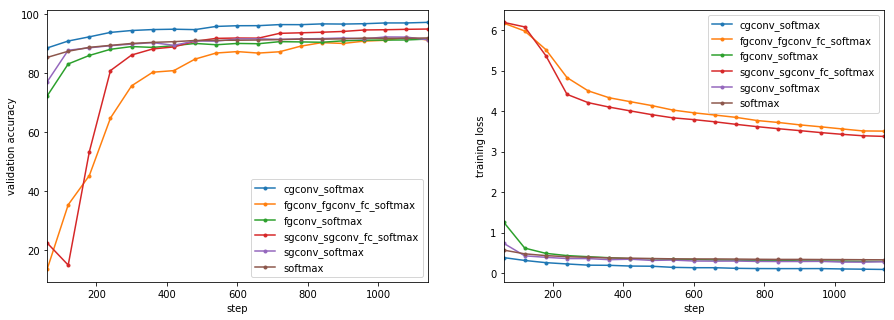

In [21]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))